In [1]:
from itertools import pairwise

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from flax import nnx
from jax import random
from jaxtyping import Array, Float, Int
from numpyro.contrib.module import nnx_module
from numpyro.handlers import seed, trace
from numpyro.infer import Predictive
from pydantic import BaseModel

numpyro.set_host_device_count(n=10)

rng_key = random.PRNGKey(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
class DataGenerationParameters(BaseModel):
    num_train: int
    num_test: int
    feature_dim: int
    z_gap: float
    y_gap: float


data_generation_parameters = DataGenerationParameters(
    num_train=10_000,
    num_test=2_000,
    feature_dim=10,
    z_gap=1.0,
    y_gap=3.0,
)

In [15]:
def generate_data(
    num_data: int, feature_dim: int, z_gap: float, y_gap: float
) -> tuple[
    Float[Array, "num_data feature_dim"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
    Int[Array, " num_data"],
]:
    # Latent confounder z is binary.
    with numpyro.plate("num_data", num_data):
        z = numpyro.sample("z", dist.Bernoulli(0.5))

        # Covariates x are normally distributed, with higher variance for z=1.
        with numpyro.plate("feature_dim", feature_dim):
            x = numpyro.sample("x", dist.Normal(z * z_gap, 5 * z + 3 * (1 - z))).T

        # Treatment t is binary, with higher probability for z=1.
        t = numpyro.sample("t", dist.Bernoulli(0.75 * z + 0.25 * (1 - z)))

        # Outcome y is binary, with higher probability for z=1 and t=1.
        y = numpyro.sample("y", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t - 1))))

        # Compute true c-specific CATE for evaluation.
        t0_t1 = jnp.array([[0.0], [1.0]])
        y_t0_t1 = numpyro.sample(
            "y_t0_t1", dist.Bernoulli(logits=y_gap * (z + 2 * (2 * t0_t1 - 1)))
        )

        y_t0 = y_t0_t1[0]
        y_t1 = y_t0_t1[1]

        true_cates = y_t1 - y_t0

        return (x, t, y, z, true_cates)

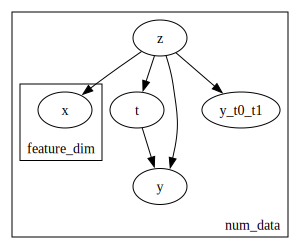

In [16]:
numpyro.render_model(
    generate_data,
    model_kwargs={
        "num_data": data_generation_parameters.num_train,
        "feature_dim": data_generation_parameters.feature_dim,
        "z_gap": data_generation_parameters.z_gap,
        "y_gap": data_generation_parameters.y_gap,
    },
)

In [17]:
x_train: Float[Array, "num_train feature_dim"]
t_train: Int[Array, " num_train"]
y_train: Int[Array, " num_train"]

rng_key, rng_subkey = random.split(rng_key)

x_train, t_train, y_train, _, _ = trace(seed(generate_data, rng_subkey))(
    num_data=data_generation_parameters.num_train,
    feature_dim=data_generation_parameters.feature_dim,
    z_gap=data_generation_parameters.z_gap,
    y_gap=data_generation_parameters.y_gap,
)


x_test: Float[Array, "feature_dim num_test"]
z_test: Int[Array, " num_test"]
true_cates: Float[Array, " num_test"]

x_test, _, _, z_test, true_cates = trace(seed(generate_data, rng_subkey))(
    num_data=data_generation_parameters.num_test,
    feature_dim=data_generation_parameters.feature_dim,
    z_gap=data_generation_parameters.z_gap,
    y_gap=data_generation_parameters.y_gap,
)

In [18]:
class FullyConnected(nnx.Module):
    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ) -> None:
        self.layers = nnx.List([])

        layer_dims = [din, *hidden_layers, dout]

        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x: Array) -> Array:
        for layer in self.layers[:-1]:
            x = jax.nn.elu(layer(x))
        return x


class DiagNormalNet(FullyConnected):
    # Fully connected neural network with ELU activations,
    # followed by a diagonal Gaussian.
    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ):
        assert len(hidden_layers) >= 2
        hidden_layers = [*hidden_layers[:-1], hidden_layers[-1] * 2]
        super().__init__(din, dout, hidden_layers, rngs=rngs)

    def __call__(self, x: Array) -> tuple[Array, Array]:
        loc, scale = jnp.split(super().__call__(x), 2, axis=-1)
        return loc, jax.nn.softplus(scale)

In [22]:
class ModelParameters(BaseModel):
    feature_dim: int
    hidden_dim: int
    latent_dim: int
    num_layers: int


model_parameters = ModelParameters(
    feature_dim=x_train.shape[1],
    latent_dim=5,
    hidden_dim=200,
    num_layers=3,
)
model_parameters

ModelParameters(feature_dim=10, hidden_dim=200, latent_dim=5, num_layers=3)

In [23]:
rng_key, rng_subkey = random.split(rng_key)

x_nn_module = DiagNormalNet(
    din=model_parameters.latent_dim,
    dout=model_parameters.feature_dim,
    hidden_layers=[model_parameters.latent_dim]
    + [model_parameters.hidden_dim] * model_parameters.num_layers
    + [model_parameters.feature_dim],
    rngs=nnx.Rngs(rng_subkey),
)

x_nn_module(jnp.ones(model_parameters.latent_dim))[0].shape

(10,)

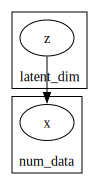

In [42]:
rng_key, rng_subkey = random.split(rng_key)

x_nn_module = DiagNormalNet(
    din=model_parameters.latent_dim,
    dout=model_parameters.feature_dim,
    hidden_layers=[model_parameters.latent_dim]
    + [model_parameters.hidden_dim] * model_parameters.num_layers
    + [model_parameters.feature_dim],
    rngs=nnx.Rngs(rng_subkey),
)


def model(x: Float[Array, "feature_dim num_data"], latent_dim: int):
    num_data, n_features = x.shape

    with numpyro.plate("latent_dim", latent_dim):
        z = numpyro.sample("z", dist.Normal(0, 1))

    x_nn = nnx_module("x_nn", x_nn_module)
    x_nn_z = x_nn(z)

    with numpyro.plate("num_data", num_data):
        x_loc = x_nn_z[0][:, None]
        x_scale = x_nn_z[1][:, None]
        x = numpyro.sample("x", dist.Normal(x_loc, x_scale))


numpyro.render_model(
    model, model_kwargs={"x": x_train, "latent_dim": model_parameters.latent_dim}
)

In [10]:
x_train.shape

(10, 10000)

In [11]:
rng_key, rng_subkey = random.split(rng_key)

Predictive(model, num_samples=100)(
    rng_subkey, x=x_train, latent_dim=model_parameters.latent_dim
)["z"].shape

(10,)
10


(100, 5)

In [12]:
x_train.shape

(10, 10000)